# DES Y1 Buzzard catalog building and hierarchical N(z) sampling
This demo notebook is divided into two sections:
- Read an input catalogue with observed magnitudes and true redshifts and generate a conditional probability
$$ P(\{ \hat F_{b,g} \} | t,z,m) $$
- Run the hierarchical sampling of Leistedt, Morlock & Peiris (2016) to recover the  distributions

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
import seaborn as sns 
import itertools
from astropy.io import fits
sns.set_style("white")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(["#9b59b6", "#95a5a6", 
                                   "#e74c3c", "#3498db", 
                                   "#34495e", "#2ecc71"]))

# BPZ Prior
This is the HDFN prior from Benitez, adapted from the BPZ code.
This tells us what is the expected probability distribution of sources given its redshift $z$, its reference magnitude $m$ and its galaxy type $t$.

The function takes as argument the an array of redshift values, a magnitude and the list of number of templates corresponding to Spirals, Ellipticals, and Starburst galaxies used to classify galaxies into types.


In [2]:
# This is the prior HDFN prior from Benitez 2000, adapted from the BPZ code.
# This could be replaced with any redshift, magnitude, and type distribution.
def bpz_prior(z, m, nt):
    nz = len(z)
    momin_hdf = 20.
    if m>32.: m = 32.
    if m<20.: m = 20.    
    # nt Templates = nell Elliptical + nsp Spiral + nSB starburst
    try:  # nt is a list of 3 values
        nell, nsp, nsb = nt
    except:  # nt is a single value
        nell = 1  # 1 Elliptical in default template set
        nsp = 2   # 2 Spirals in default template set
        nsb = nt - nell - nsp  # rest Irr/SB
    nn = nell, nsp, nsb
    nt = sum(nn)
    # See Table 1 of Benitez00
    a  = 2.465,  1.806,  0.906
    zo = 0.431,  0.390,  0.0626
    km = 0.0913, 0.0636, 0.123
    k_t= 0.450,  0.147
    a  = np.repeat(a, nn)
    zo = np.repeat(zo, nn)
    km = np.repeat(km, nn)
    k_t= np.repeat(k_t, nn[:2])
    # Fractions expected at m = 20: 35% E/S0, 50% Spiral, 15% Irr
    fo_t = 0.35, 0.5
    fo_t = fo_t / np.array(nn[:2])
    fo_t = np.repeat(fo_t, nn[:2])
    dm = m-momin_hdf
    zmt = np.clip(zo+km*dm,0.01,15.)
    zmt_at_a = zmt**(a)
    zt_at_a = np.power.outer(z,a)
    #Morphological fractions
    nellsp = nell + nsp
    f_t = np.zeros((len(a),),float)
    f_t[:nellsp] = fo_t*np.exp(-k_t*dm)
    f_t[nellsp:] = (1.-np.add.reduce(f_t[:nellsp]))/float(nsb)
    #Formula: zm=zo+km*(m_m_min)  and  p(z|T,m)=(z**a)*exp(-(z/zm)**a)
    p_i = zt_at_a[:nz,:nt]*np.exp(-np.clip(zt_at_a[:nz,:nt]/zmt_at_a[:nt],0.,700.))
    #This eliminates the very low level tails of the priors
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = np.where(np.less(p_i[:nz,:nt]/norm[:nt],1e-2/float(nz)),
              0.,p_i[:nz,:nt]/norm[:nt])
    norm = np.add.reduce(p_i[:nz,:nt],0)
    p_i[:nz,:nt] = p_i[:nz,:nt]/norm[:nt]*f_t[:nt]
    return p_i

In [3]:
# This is the fine grid used to sample redshifts from.
# It is not the same as the grid used for the 3D histogram

z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# Just some boolean indexing of templates used. Needed later for some BPZ fcts.
selectedtemplates = np.repeat(False, 8)

# Using all templates
templatetypesnb = (1, 2, 5) # nb of ellipticals, spirals, and starburst used in the 8-template library.
selectedtemplates[:] = True

# Uncomment that to use three templates using
#templatetypesnb = (1,1,1) #(1,2,8-3) 
#selectedtemplates[0:1] = True
nt = sum(templatetypesnb)

ellipticals = ['El_B2004a.sed'][0:templatetypesnb[0]]
spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed'][0:templatetypesnb[1]]
irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed',
           'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed'][0:templatetypesnb[2]]
template_names = [nm.replace('.sed','') for nm in ellipticals+spirals+irregulars]

# Convenient function for template names
def mknames(nt):
    return ['Elliptical '+str(i+1) for i in range(nt[0])] \
    + ['Spiral '+str(i+1) for i in range(nt[1])]\
    + ['Starburst '+str(i+1) for i in range(nt[2])]
names = mknames(templatetypesnb)

Lets plot the BPZ prior for some templates at a particular magnitude value.
We can chooose whatever value for m. If it is less than 20 or higher than 32, then the function will adjust it to be either of the limits. We choose $m = 22.0$.
For the template numbers, we choose $n_t = (1,2,5)$ which is exactly the corresponding number of templates used in BPZ: 1 Elliptical, 2 Spirals, and 5 Starbursts.

The plot will show only 3 curves, as equal types have the same parameters defined in the prior function.
This effectively means that the priors are identical independent of subtype. The change in likelihood computation only comes from the SED template employed for each one.

/home/juancordero/.local/lib/python3.5/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


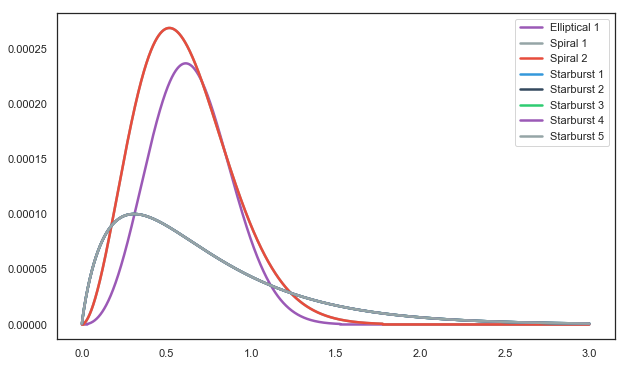

In [4]:
# Use the p(z,t,m) distribution defined above
m = 22.0 # some reference magnitude
p_z__t_m = bpz_prior(z_grid, m, templatetypesnb)

# Plot the priors for these templates
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
p = ax.plot(z_grid, p_z__t_m)
ax.legend(p, labels=names)

Now we plot the BPZ templates from Coleman (1980). They are normalized to have the same relative flux at 7000 $A^{\circ}$.

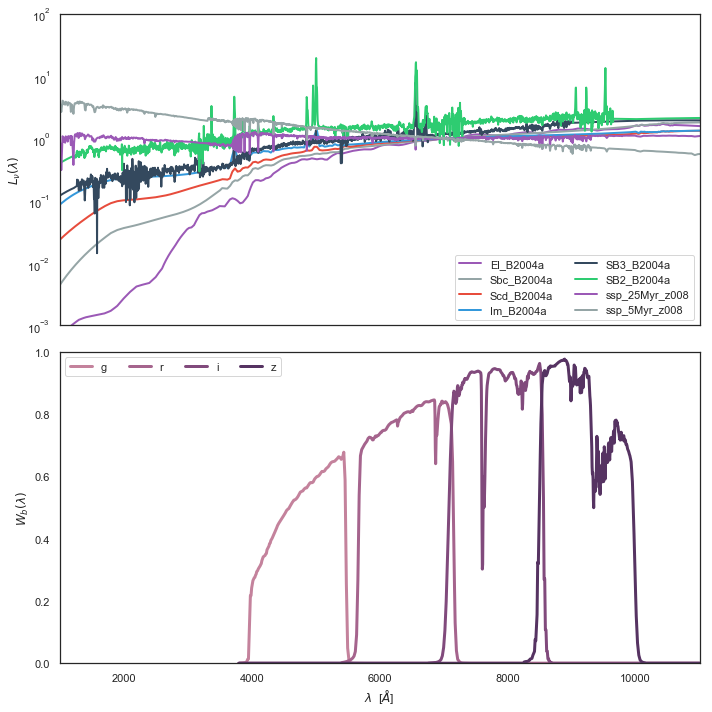

In [5]:
# Load and plot the templates and filters
palette = itertools.cycle(sns.color_palette())
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
for i, template_name in enumerate(template_names):
    data = np.genfromtxt('./seds/'+template_name+'.sed')
    wavelength, template_sed = data[:,0], data[:,1] * data[:,0]**2
    fnorm = np.interp(7e3, wavelength, template_sed)
    axs[0].plot(wavelength, (template_sed / fnorm), label=template_names[i], 
                c=next(palette), lw=2)
axs[0].legend(loc='lower right', ncol=2)
axs[0].set_ylabel(r'$L_\nu(\lambda)$')
axs[0].set_yscale('log')
axs[0].set_ylim([1e-3, 1e2])

ab_filters = ['g', 'r', 'i', 'z']
palette = itertools.cycle(sns.cubehelix_palette(5, light=0.6))
filters = [np.genfromtxt('./filters/'+band+'_DES_Y1.res') for band in ab_filters]
for f, data in zip(ab_filters, filters):
    axs[1].plot(data[:,0], data[:,1], label=f, c=next(palette), lw=3)
axs[1].set_xlim([1e3, 1.1e4])
axs[1].set_ylim([0, 1.00])
axs[1].set_xlabel(r'$\lambda$  [$\AA$]')
axs[1].set_ylabel(r'$W_b(\lambda)$')
axs[1].legend(loc='upper left', ncol=5)
fig.tight_layout()

Here we define the probability of an arbitrary galaxy to have a particular magnitude in the reference magnitude band.
The probability model is defined by an exponential

$$P(m_I) = m_I^\alpha e^{-\left(\frac{m_I}{m_{I,\tt{lim}} - m_{I,\tt{off}}}\right)^\beta}$$

At the same time, the distribution of errors depends on the measured magnitude of the objects, and the limiting magnitude of the survey.

# DES Y1 sample catalog

We read a subsampled catalog of DES Y1 GOLD objects, which include fluxes in griz bands and their respective errors. We use this catalog to build the conditional probability

$$ P(\{ \hat F_{b,g}\}| t,z,m) $$

In [6]:
catalog = fits.open('DES_Y1_Buzzard/Chinchilla_0Y1a_v1_matched_16.fits')[1]

#We apply a few arbitrary cuts to generate a catalog of well behaved objects

data = catalog.data
data = data[data['MAG_G'] < 30 ]
data = data[data['MAG_R'] < 30 ]
data = data[data['MAG_I'] < 30 ]
data = data[data['MAG_Z'] < 30 ]
data = data[data['MAG_G'] > 15 ]
data = data[data['MAG_R'] > 15 ]
data = data[data['MAG_I'] > 15 ]
data = data[data['MAG_Z'] > 15 ]

nobj = len(data)

mag_name = 'MAG_'
magerr_name = 'MAGERR_'

mags = np.zeros((len(ab_filters), nobj))
magerrs = np.zeros((len(ab_filters), nobj))

z_true = np.array(data['Z'])

for i, b in enumerate(ab_filters):
    
    mags[i] = np.array(data[mag_name+b.upper()])
    magerrs[i] = np.array(data[magerr_name+b.upper()])

/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/juancordero/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [7]:
data.shape

(1392280,)

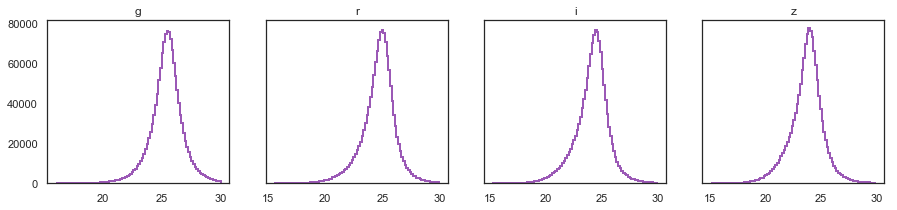

In [8]:
f, axes = plt.subplots(1,mags.shape[0], figsize=(15,3), sharey=True)
for i in range(mags.shape[0]):
    axes[i].hist(mags[i], bins = 100, histtype='step', linewidth = 2)
    axes[i].set_title(ab_filters[i])
    
plt.show()

In [9]:
# Define the edges of the redshift, type and imagnitude grid
imag_grid = np.linspace(15, 30, num=200)
z_grid_edges_coarse = np.arange(0.0, 3.0, 0.2)
types_edges = np.arange(nt+1)-0.5
imag_grid_edges = np.linspace(15, 30, num=10)


Following a similar strategy to that of BPZ, we will generate the flux-redshift models which are used to fit the observed magnitudes to the template SEDs.
For each galaxy type, that is the flux integrated under the filter curve as a function of SED redshift.
Two version are stored. The 'continuous' version is obtained using a fine discretization of the redshift range, while the 'coarse' version is obtained based on the same redshift binning used for the analysis.

In [10]:
# Approximate luminosity distance for flat LCDM
def DL(z):
    return np.exp(30.5 * z**0.04 - 21.7)

filters = ['g', 'r', 'i', 'z']

# We will now use the BPZ routines to load the flux-redshift model for each template.
# We'll have interpolated and discretized versions
nf = len(filters)
nz = len(z_grid)
f_mod = np.zeros((nz,nt,nf))*0.
f_mod_interps = np.zeros((nt, nf), dtype=interp1d)
lambdaRef = 4.5e3
for it in range(nt):
    seddata = np.genfromtxt('./seds/' + template_names[it] + '.sed')
    seddata[:, 1] *= seddata[:, 0]**2. / 3e18 # Not sure what this is
    ref = np.interp(lambdaRef, seddata[:, 0], seddata[:, 1])
    seddata[:, 1] /= ref
    sed_interp = interp1d(seddata[:, 0], seddata[:, 1])
    for jf in range(nf):
        filter_data = np.genfromtxt('./filters/' + filters[jf] + '_DES_Y1.res')
        xf, yf = filter_data[:, 0], filter_data[:, 1]
        yf /= xf  # divide by lambda
        # Only consider range where >1% max
        ind = np.where(yf > 0.01*np.max(yf))[0]
        lambdaMin, lambdaMax = xf[ind[0]], xf[ind[-1]]
        norm = np.trapz(yf, x=xf)
        for iz in range(z_grid.size):
            opz = (z_grid[iz] + 1)
            xf_z = np.linspace(lambdaMin / opz, lambdaMax / opz, num=5000)
            yf_z = interp1d(xf / opz, yf)(xf_z)
            ysed = sed_interp(xf_z)
            f_mod[iz, it, jf] = np.trapz(ysed * yf_z, x=xf_z) / norm
            f_mod[iz, it, jf] *= opz**2. / DL(z_grid[iz])**2. / (4*np.pi)
        # This is an actual interpolator. Given any z value it will return the interpolation at that z
        f_mod_interps[it, jf] = InterpolatedUnivariateSpline(z_grid, f_mod[:, it, jf]) 

Now that all the flux models are defined, we assign mock noisy *ugriz* magnitudes to the galaxies in the sample. We keep the record of the true magnitudes as well.
Instead of storing magnitudes, we keep the fluxes to work easily with them in the likelihood estimation.
If it is the turn of the the band we have chosed before, we simply copy the values we created before.
In the case of the other bands, we use the flux-redshift models from before to obtain the flux in the particular specific band, since we already have the redshift for each of the generated objects.

In [11]:
# f_mod denotes the (discretized or continuous) model flux-redshift curves
# Let's now get magnitudes for all the objects we've drawn
f_obs_err = magerrs.T
f_obs = mags.T

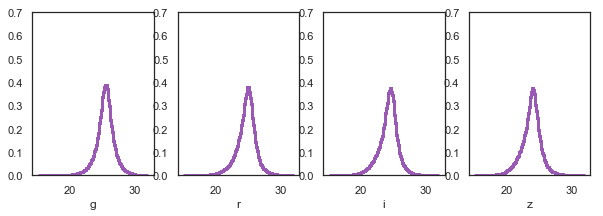

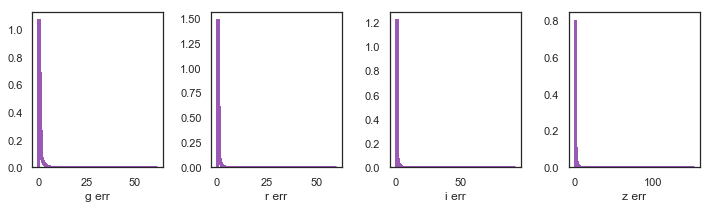

In [12]:
# Let's visualize the fluxes
fig, axs = plt.subplots(1, nf, figsize=(10,3))
for jf in range(nf):
    axs[jf].hist(f_obs[:,jf], density=True, 
                 range=[imag_grid.min(), imag_grid.max()+2], 
                 bins=150, histtype='step', lw=3)
    axs[jf].set_ylim([0,0.7])
    axs[jf].set_xlabel(filters[jf])
fig, axs = plt.subplots(1, nf, figsize=(10,3))
for jf in range(nf):
    axs[jf].hist(f_obs_err[:,jf], density=True, bins=150, histtype='step', lw=3)
    axs[jf].set_xlabel(filters[jf]+' err')
fig.tight_layout()

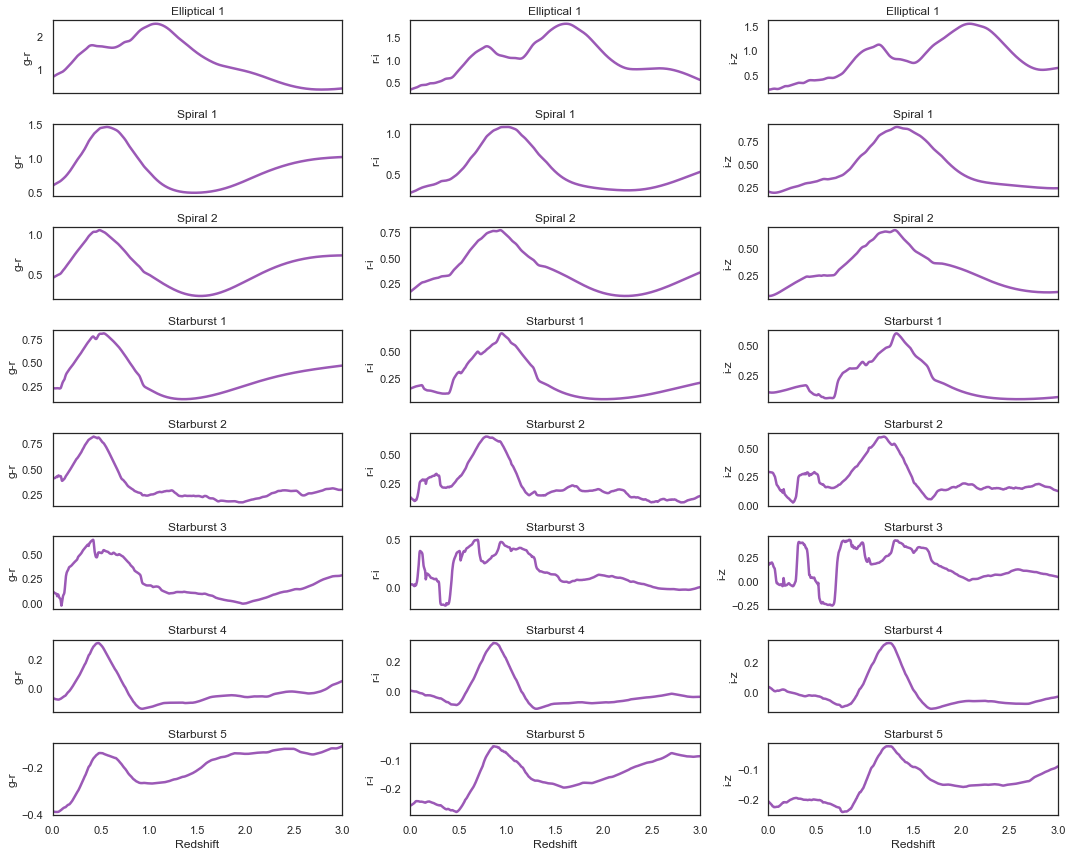

In [13]:
# Let's plot the model and the noisy fluxes for our mock catalogue
# If I had the BPZ best fit templates I could assign types to each of the objects to compare agains the 
# f_mod tracks. Will do it tomorrow maybe? When I learn to use the freaking SQL routine.


fig, axs = plt.subplots(nt, nf-1, figsize=(15,nt*1.5), sharex=True, sharey=False)
for it in range(nt):
#     ind = (types == it)
    for jf in range(nf-1):
        theax = axs[it,jf]
        colour = -2.5*np.log10(np.clip(f_mod[:,it,jf] / f_mod[:,it,jf+1], 1e-5, 1e5))
        colourobj = f_obs[:,jf] - f_obs[:,jf+1]
#         p = theax.scatter(redshifts[ind], colourobj[ind], c='k', s=1)
        p = theax.plot(z_grid, colour)
        theax.set_title(names[it])
        theax.set_ylabel(filters[jf]+'-'+filters[jf+1])
for jf in range(nf-1):
    axs[-1,jf].set_xlabel('Redshift')
theax.set_xlim([0,3])
fig.tight_layout()

Not entire sure how this function does it exactly, but it returns the likelihood of a galaxy redshift and type, given its observed fluxes. 

$$P(\{ \hat F_{b,g} \} | t,z)$$

In [14]:
# This is a scale-free likelihood function, marginalizing over the scale of the fluxes
def scalefree_flux_likelihood(f_obs, f_obs_var,
                              f_mod, returnChi2=False):
    nz, nt, nf = f_mod.shape
    var = f_obs_var  # nz * nt * nf
    invvar = np.where(f_obs/var < 1e-6, 0.0, var**-1.0)   # nz * nt * nf
    FOT = np.sum(f_mod * f_obs * invvar, axis=2)  # nz * nt
    FTT = np.sum(f_mod**2 * invvar, axis=2)  # nz * nt
    FOO = np.dot(invvar, f_obs**2)  # nz * nt
    ellML = FOT / FTT
    chi2 = FOO - FOT**2.0 / FTT  # nz * nt
    like = np.exp(-0.5*chi2) / np.sqrt(FTT)  # nz * nt
    if returnChi2:
        return chi2 + FTT, ellML
    else:
        return like, ellML

Then, we use it to compute the likelihood for all the objects in the mock catalog.
The likelihood is computed for all templates and for all of the redshift range, so the result is an array of likelihoods as a function of both. It will peak where the galaxies have the highest likelihood of being of that specific type at that redshift.
The likelihoods are computed at a very high resolution and then binned to the redshift bin of the 3D histogram.

In [15]:
len(data)

1392280

In [16]:
# Let's use the same templates to compute the likelihood functions of all these objects
fac = 200 # This is a resolution factor
# We need to compute the likelihood at high resolution and then bin it.
# the low resolution binsize is fac * bpz_z_binsize
types_edges = np.arange(nt+1)-0.5

nobj = 20000

sample_choice = np.random.choice(np.arange(len(data)), size=nobj, replace=False)

f_obs = f_obs[sample_choice]
f_obs_err = f_obs_err[sample_choice]
z_true = z_true[sample_choice]

# ff_obs is for fluxes, f_obs is for colors
# We now need to compute the flux and flux errors from colors
ff_obs = (10.**(-.4*f_obs)) # Observed fluxes
ff_obs_err = (10.**(.4*np.abs(f_obs_err))-1.)*ff_obs # Flux errors
f_mod_log = -2.5*np.log10(f_mod) # Flux-redshift model converted to magnitude-redshift model

# This is just a bunch of redefinitions to re-bin all useful quantities
# Into a coarcer redshift binning
z_grid_binsize2 = fac * z_grid_binsize
if fac == 1:
    z_grid_edges2 = 1*z_grid_edges
else:
    z_grid_edges2 = np.array([z_grid_edges[i] for i in np.arange(0, z_grid_edges.size, fac)])
z_grid2 = (z_grid_edges2[1:] + z_grid_edges2[:-1])/2.0
len_new = z_grid.size // fac

# Compute likelihood for each object
bpz_like_fine_multitypes = np.zeros((nobj, z_grid.size, nt), dtype=float) # Binned liklihood at full resolution
bpz_like_multitypes = np.zeros((nobj, z_grid2.size, nt), dtype=float) # Coarce binned likelihood 
for i in range(nobj):
    if i % 1000 == 0: 
        print(i, end=" ") # Print number every 1000 objects.
    new_f_mod = f_mod[:,:,:] / f_mod.mean(axis=2)[:, :, None] # what is this?
    scafac = 1/np.mean(ff_obs[i,:])
    ff, ellML = scalefree_flux_likelihood(scafac*ff_obs[i,:], (scafac*ff_obs_err[i,:])**2., new_f_mod)
    bpz_like_fine_multitypes[i,:,:] = ff # Fine resolution
    for kk in range(len_new):
        bpz_like_multitypes[i,kk,:] = np.mean(ff[kk*fac:(kk+1)*fac,:], axis=0) # Re-bin
    # in case of problem:
#     if(np.sum(ff[:, types[i]]) == 0 or np.sum(bpz_like_multitypes[:, types[i]]) == 0):
#         print(i, bpz_like_fine_multitypes.sum(axis=1), bpz_like_multitypes.sum(axis=1))
#         stop

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

As we can see in the plots above for 12 random objects, the peaks are quite pronounced, and the color of the peak is tied to a specific galaxy type.

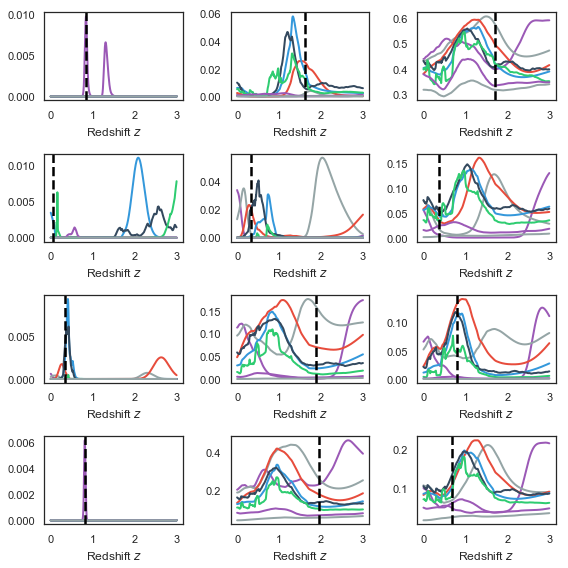

In [17]:
# plot likelihood function for a few randomly picked objects
# color coded by type.
fig2, axs = plt.subplots(4, 3, figsize=(8, 8), sharex=False, sharey=False)
axs = axs.ravel()
ri = np.random.choice(np.arange(nobj), axs.size, replace=False)
for i in range(len(ri)):
    theax = axs[i]
    theax.plot(z_grid, bpz_like_fine_multitypes[ri[i],:,:], lw=2)
#     theax.plot(z_grid2, bpz_like_multitypes[ri[i],:,:], lw=2)
    theax.axvline(z_true[ri[i]], ls='dashed', c='k')
#     theax.set_title(r'Likelihood $p(F|z,t)$')
    theax.set_xlabel(r'Redshift $z$')
fig2.tight_layout()

I have no idea what is going on here. So, basically we have the likelihood
$$ P(\{ \hat F_b\}|z,t)$$
which comes from the scale-free likelihood defined above. Now, the likelihood is multiplied by a Gaussian likelihood for the reference magnitude
$$ P(\{ \hat F_b\} |z,t,m) = P(\{ \hat F_b\}|z,t) P(m) $$

In [18]:
reffilter = 2

imags = f_obs[:,reffilter]

# Also need to multiply with gaussian likelihood for reference magnitude, since we will infer p(z, t, m)
def gauss_like_int(grid_edges, mus, sigmas):
    nobj = mus.size
    nz = grid_edges.size-1
    res = np.zeros((nobj, nz))
    fac = np.sqrt(2) * sigmas
    for iz, (zlo, zhi) in enumerate(zip(grid_edges[:-1], grid_edges[1:])):
        res[:,iz] = np.abs(-(erfc((zhi-mus)/fac) - erfc((zlo-mus)/fac))/2.0)
    return res
    
nm = 10
nz2 = z_grid2.size
imag_grid_edges = np.linspace(16, 26, num=nm+1)
imag_grid = (imag_grid_edges[1:] + imag_grid_edges[:-1])/2.0
bpz_like_ztm = np.zeros((nobj, nz2, nt, nm), dtype=float)
imaglike = gauss_like_int(imag_grid_edges, f_obs[:,reffilter], f_obs_err[:,reffilter])
for i in range(nobj):
    bpz_like_ztm[i,:,:,:] = np.outer(bpz_like_multitypes[i,:,:], imaglike[i,:]).reshape((nz2, nt, nm))
    
imaglocs = np.zeros((nobj,), dtype=int)
for iz, (zlo, zhi) in enumerate(zip(imag_grid_edges[:-1], imag_grid_edges[1:])):
    ind = np.logical_and(imags > zlo, imags <= zhi)
    if ind.sum()>0:
        imaglocs[ind] = iz

Here we compute the maximum likelihood redshifts for all objects and separate the full sample int 4 chuncks to run the two-step Gibbs sampler with MPI.

In [19]:
# Compute z_MAP in case it is useful, and also write likelihoods to 4 files
z_grid_full = np.outer(z_grid, np.ones(nt)).ravel()
zpeaks = np.zeros((nobj,), dtype=float)
for i in range(nobj):
    if i % 1000 == 0:
        print(i, end=" ")
    pospeak = np.argmax(bpz_like_multitypes[i,:,:].ravel())
    zpeaks[i] = z_grid_full[pospeak]
  
def chunks(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg
    return out

# Save each chunk of 4D python numpy array into files
nchunks = 4
lines_out = np.arange(nobj)#lines#np.arange(nobj_selec)
for i, ind in enumerate(chunks(lines_out, nchunks)):
    fname = 'bpz_DES_Y1_buzzard_histlike_ztm_'+str(nchunks)+'_'+str(i+1)+'.npy'
    np.save(fname, bpz_like_ztm[ind,:,:,:])

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 

In [20]:
# Run the following command in the terminal to run the Hierarchical sampler
# of Leistedt, Morlock & Pedediris (2016) in parallel over the 4 chuncks.
# Try with 1000 and then move to 1e4 samples.
# Don't use with >100,000 objects because it is memory greedy! 
# There is a new light version of the model+sampler coming.

!mpirun -np 4 ./bayeshist.py bpz_DES_Y1_buzzard_histlike_ztm_4 1000

('Input parameters:', ['./bayeshist.py', 'bpz_DES_Y1_buzzard_histlike_ztm_4', '1000'])
Running on 4 cores
('Read file', 'bpz_DES_Y1_buzzard_histlike_ztm_4_3.npy', 'and found', 5000, 'objects')
('Read file', 'bpz_DES_Y1_buzzard_histlike_ztm_4_1.npy', 'and found', 5000, 'objects')
('Read file', 'bpz_DES_Y1_buzzard_histlike_ztm_4_4.npy', 'and found', 5000, 'objects')
('Read file', 'bpz_DES_Y1_buzzard_histlike_ztm_4_2.npy', 'and found', 5000, 'objects')
Broadcasted hbs
('Saving', 7, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 14, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 21, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 28, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 35, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 42, '

('Saving', 532, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 539, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 546, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 553, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 560, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 567, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 574, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 581, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 588, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy', '(0.12', 'sec per sample)')
('Saving', 595, 'samples to', 'bpz_DES_Y1_buzzard_histlike_ztm_4

In [23]:
fbs_samples_ztm = np.load('bpz_DES_Y1_buzzard_histlike_ztm_4_post.npy')
fbs_samples_zt = fbs_samples_ztm[:,:,:,:].sum(axis=3)
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)

samples = len(fbs_samples_z)

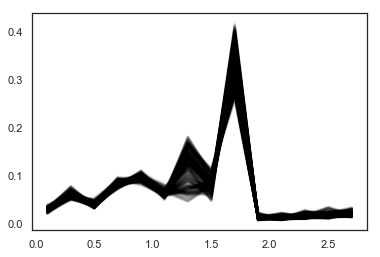

In [24]:
for i in range(samples):
    plt.plot(z_grid2, fbs_samples_z[i], alpha = 0.05, color = 'k')

In [30]:
linewidth = 1.5
binsize = (z_grid2[1] - z_grid2[0])

NameError: name 'types' is not defined

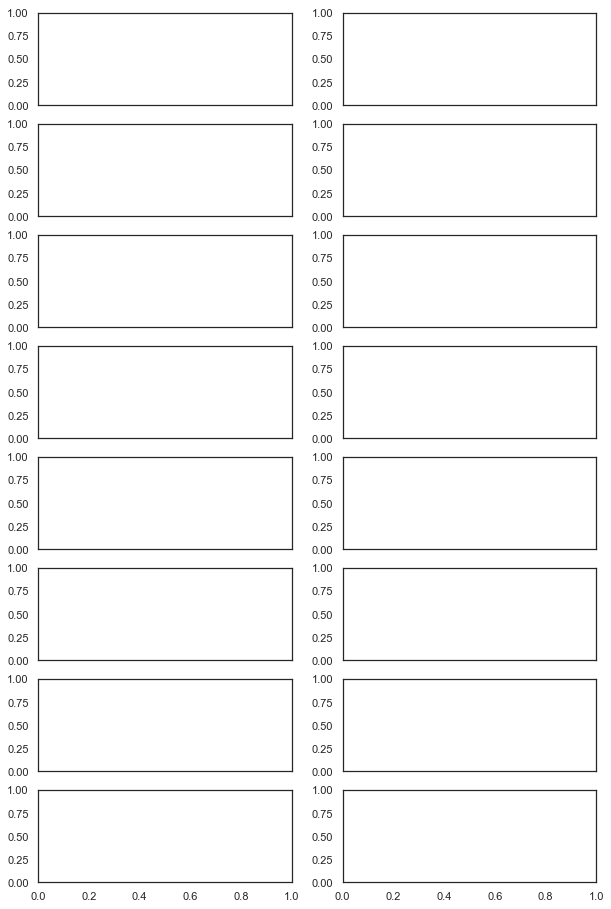

In [31]:
fig, axs = plt.subplots(nt, 2, figsize=(10, 16), sharex=True)
for i in range(nt):
    ind = np.where(types[lines_out] == i)[0]
    
    N_t = float(hist_noiseless_zt[:,i].sum())
    
    stacked_like = bpz_like_ztm[:,:,i,:].sum(axis=2).mean(axis=0) #/ N_t
    truth = hist_noiseless_zt[:,i] / N_truth
    
    indv = (truth > np.max(truth)/50.0)
    offset = z_grid_binsize2/18.0
    ax = axs[i, 0]
    ax.plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
            np.concatenate(([truth[0]], truth)), color='k', lw=linewidth, 
            drawstyle='steps', label='True distribution')
    
    df = pd.DataFrame(fbs_samples_zt[:,:,i], columns=z_grid2)
    sns.violinplot(data=df, width=4*binsize, scale_hue=False, scale='width', ax=ax,
                  inner=None, palette="coolwarm")
    v1, v2 = ax.get_ylim()
    ax.set_ylim([0, v2])
    if i == 1:
        ax.set_ylim([0, 0.05])
    ax.set_ylim([0, 0.95*v2])
    ax.set_xticks(np.arange(0, 3, 0.5)/binsize)
    ax.set_xticklabels(np.arange(0, 3, 0.5))
    ax.set_ylabel(names[i])
    
    ax = axs[i, 1]
    ax.plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
            np.concatenate(([0], 0*truth)), color='k', lw=linewidth, marker=None)
    df = pd.DataFrame((fbs_samples_zt[:,:,i]-truth), columns=z_grid2)
    sns.violinplot(data=df, width=4*binsize, scale_hue=False, scale='width', ax=ax,
                  inner=None, palette="coolwarm")
    v1, v2 = ax.get_ylim()
    v3 = np.max([np.abs(v1), np.abs(v2)])
    #v3 = 0.024
    ax.set_ylim([-v3, v3])
    ax.set_xticks(np.arange(0, 3, 0.5)/binsize)
    ax.set_xticklabels(np.arange(0, 3, 0.5))
axs[0, 0].set_title(r'$N(z)$')
axs[0, 1].set_title(r'$N(z)$ residuals')
axs[-1, 0].set_xlabel(r'Redshift $z$')
axs[-1, 1].set_xlabel(r'Redshift $z$')
# fig.tight_layout()
fig.subplots_adjust(wspace=0.3)



No handles with labels found to put in legend.


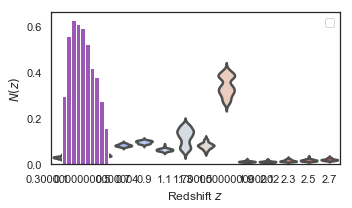

In [34]:
# Same but with type marginalized.
fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharex=False)
axs = [axs]
stacked_like = bpz_like_ztm[:,:,:].sum(axis=3).sum(axis=2).sum(axis=0)
stacked_like /= nobj
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)
axs[0].hist(z_true, density=True)
# hist_noiseless_z = hist_noiseless_ztm.sum(axis=(1,2))
# hist_noiseless_z /= hist_noiseless_z.sum()
df = pd.DataFrame(fbs_samples_z[:,:], columns=z_grid2)
t1 = sns.violinplot(data=df, width=4*binsize, scale_hue=False, scale='width', ax=axs[0],
              inner=None, palette="coolwarm", label=r'Recovered distribution')
# t3 = axs[0].plot(np.concatenate(([z_grid2[0]/binsize-1.0], z_grid2/binsize)), 
#             np.concatenate(([0], hist_noiseless_z)), color='k', lw=linewidth, 
#             drawstyle='steps', label=r'True distribution')
axs[0].legend()
axs[0].set_ylabel(r'$N(z)$')
axs[0].set_xlabel(r'Redshift $z$')
fig.tight_layout()

(array([0.17223975, 0.42637128, 0.56745649, 0.5509892 , 0.60306168,
        0.65602447, 0.63866663, 0.57858332, 0.61463285, 0.57235272,
        0.54030752, 0.50959811, 0.4579707 , 0.38275532, 0.37607896,
        0.38319998, 0.33379789, 0.21808152, 0.16022282, 0.15888796]),
 array([0.01755936, 0.12990277, 0.24224617, 0.35458958, 0.46693298,
        0.5792764 , 0.69161975, 0.8039632 , 0.91630656, 1.02865   ,
        1.1409934 , 1.2533368 , 1.3656802 , 1.4780236 , 1.590367  ,
        1.7027104 , 1.8150538 , 1.9273973 , 2.0397406 , 2.152084  ,
        2.2644274 ], dtype=float32),
 <a list of 20 Patch objects>)

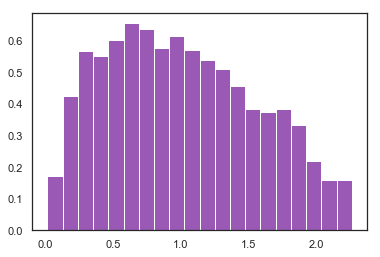

In [35]:
plt.hist(z_true, bins=20, density=True)

In [ ]:
# Now plot the samples of the full model versus a naive dirichlet,
# To show the impact of the model hierarchy and also bin-bin correlations.

def dirichlet(size, alphas):
    gammabs = np.array([np.random.gamma(alpha+1, size=size) for alpha in alphas])
    fbs = gammabs / gammabs.sum(axis=0)
    return fbs.T

from corner import hist2d
myrange = np.arange(0, 14)

fig, axs = plt.subplots(myrange.size, myrange.size, figsize=(13, 13), sharex=False, sharey=False)
#axs = axs.ravel()
off = 0
lw = 1
nbins = 20
hist_noiseless_z = hist_noiseless_ztm.sum(axis=2).sum(axis=1)
truth_z = truth_ztm_full.sum(axis=2).sum(axis=1)
truth = truth_z / float(truth_ztm_full.sum())
#fbs_samples_z_noerrors = dirichlet(2e4, hist_noiseless_z)
nobnoe = int(1e5)
fbs_samples_ztm_noerrors = dirichlet(nobnoe, hist_noiseless_ztm.ravel()).reshape((nobnoe, nz, nt, nm))
fbs_samples_z_noerrors = fbs_samples_ztm_noerrors[:,:,:,:].sum(axis=3).sum(axis=2)
fbs_samples_z = fbs_samples_ztm[:,:,:,:].sum(axis=3).sum(axis=2)
levels = 1.0 - np.exp(-0.5 * np.arange(1.0, 2.1, 1.0) ** 2)
sc = 4
formatter = FormatStrFormatter('%.3f')
for ibin in myrange:
    mi = truth[ibin]#
    mmi = np.mean(fbs_samples_z[:,ibin])
    si = np.std(fbs_samples_z[:,ibin])
    ri = [max([0, mi-sc*si]), mi+sc*si]
    for jbin in myrange:
        mj = truth[jbin]#
        mmj = np.mean(fbs_samples_z[:,jbin])
        sj = np.std(fbs_samples_z[:,jbin])
        rj = [max([0, mj-sc*sj]), mj+sc*sj]
        theax = axs[ibin-myrange[0], jbin-myrange[0]]
        theax.locator_params(nbins=2)
        txt = str(ibin+1)+'-th bin, $z\in[%1.2g' % (z_grid[jbin]-binsize/2)+', %1.2g' % (z_grid[jbin]+binsize/2)+']$'
        txt = ''
        if (jbin < ibin):
            off += 1
            theax.axvline(truth[jbin], color='gray', ls='dashed')
            theax.axhline(truth[ibin], color='gray', ls='dashed')
            theax.set_yticks([truth[ibin]])
            theax.set_xticks([truth[jbin]])
            theax.yaxis.set_major_formatter(formatter)
            theax.xaxis.set_major_formatter(formatter)
            hist2d(fbs_samples_z_noerrors[:,jbin], fbs_samples_z_noerrors[:,ibin], #range=[ri, rj],
                   bins=nbins, ax=theax, color='red', hist2d_kwargs={'linewidth': lw},
                   plot_density=False, plot_datapoints=False, levels=levels)
            hist2d(fbs_samples_z[:,jbin], fbs_samples_z[:,ibin], #range=[ri, rj],
                   bins=nbins, ax=theax, color='k', hist2d_kwargs={'linewidth': lw},
                   plot_density=False, plot_datapoints=False, levels=levels)
            theax.scatter(truth[jbin], truth[ibin], marker='s', s=50, color='k')
    
            theax.set_xlim(rj)
            theax.set_ylim(ri)
        else:
            if ibin == jbin:
                theax.set_title(txt, fontsize=15)
                y, x = np.histogram(fbs_samples_z[:,ibin], bins=2*nbins, range=ri)
                theax.plot((x[1:]+x[:-1])/2., y/float(y.max()), 'k')
                y, x = np.histogram(fbs_samples_z_noerrors[:,ibin], bins=2*nbins, range=ri)
                theax.plot((x[1:]+x[:-1])/2., y/float(y.max()), 'r')
                theax.axvline(truth[ibin], color='gray', ls='dashed')
                theax.set_yticks([])
                theax.set_xlim(ri)
                theax.set_ylim([0, 1.1])
                theax.set_xticks([truth[ibin]])
                theax.xaxis.set_major_formatter(formatter)
            else:
                plt.delaxes(theax)
        if (jbin > myrange[0]):
            theax.set_yticklabels([])
        if (ibin < myrange[-1]):
            theax.set_xticklabels([])
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)